# ISW table transformation

## Import

In [43]:
import numpy as np
import pandas as pd
import re
import string

import nltk
nltk.download('punkt_tab')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfTransformer as tfidf
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Some cleaning

In [44]:
df_raw = pd.read_csv("../data/ISW.csv")

df_result = pd.DataFrame()

In [45]:
df_raw.head(10)

date  \
0  2022-02-24   
1  2022-02-25   
2  2022-02-26   
3  2022-02-27   
4  2022-02-28   
5  2022-03-01   
6  2022-03-02   
7  2022-03-03   
8  2022-03-04   
9  2022-03-05   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [46]:
df_raw.dropna(inplace=True)

deleting punctuation

In [47]:
df_raw = df_raw.apply(lambda col: col.map(lambda x: x.lower() if isinstance(x, str) else x))

def clean_text(x):
    if isinstance(x, str):
        x = x.lower()
        x = re.sub(r'https?://\S+|www\.\S+', '', x)
        punctuation_to_remove = ''.join(c for c in string.punctuation if c != '-')
        x = re.sub(f'[{re.escape(punctuation_to_remove)}]', '', x)
        x = re.sub(r'\s+', ' ', x).strip()
    return x

df_raw['content'] = df_raw['content'].map(clean_text)

# Now we will get a bag of words

In [48]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [49]:
lemming = CountVectorizer(lowercase=True, ngram_range=(1,2), stop_words='english', tokenizer=LemmaTokenizer())

X_lemma = lemming.fit_transform(df_raw['content'].fillna(''))

D:\NaUKMA\DS\H2_python_structure_and_data\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
D:\NaUKMA\DS\H2_python_structure_and_data\venv\lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'u', 'wa'] not in stop_words.
  warnings.warn(


## Redundant part for Stemming

In [50]:
class StemmerTokenizer:
    def __init__(self):
        self.sp = PorterStemmer()
    def __call__(self, doc):
        return [self.sp.stem(t) for t in word_tokenize(doc)]

In [51]:
# stemming = CountVectorizer(lowercase=True, ngram_range=(1,2), tokenizer=StemmerTokenizer())
#
# X_stemming = stemming.fit_transform(df_raw['content'].fillna(''))

## We will be using Lemmatization for the tf-idf

`As for this project we are not operating with a giant dataset, we can spend more time on converting to lemmas`

*However we'll still add column with both stemming and lemming*

In [52]:
df_raw['lemma_content'] = df_raw['content'].apply(lambda x: ' '.join(LemmaTokenizer()(x)) if isinstance(x, str) else '')
df_raw['stem_content'] = df_raw['content'].apply(lambda x: ' '.join(StemmerTokenizer()(x)) if isinstance(x, str) else '')

In [53]:
tf_idf = tfidf()
X_tf_idf = tf_idf.fit_transform(X_lemma)
X_dense = X_tf_idf.toarray()

In [54]:
pca = PCA(n_components=750)
X_pca = pca.fit_transform(X_dense)

Cumulative explained variance ratio for the first 100 components:
Components 1: 0.025
Components 2: 0.040
Components 3: 0.052
Components 4: 0.060
Components 5: 0.067
Components 6: 0.073
Components 7: 0.079
Components 8: 0.085
Components 9: 0.091
Components 10: 0.096
Components 11: 0.101
Components 12: 0.106
Components 13: 0.110
Components 14: 0.115
Components 15: 0.119
Components 16: 0.123
Components 17: 0.126
Components 18: 0.129
Components 19: 0.132
Components 20: 0.135
Components 21: 0.137
Components 22: 0.140
Components 23: 0.142
Components 24: 0.145
Components 25: 0.147
Components 26: 0.150
Components 27: 0.152
Components 28: 0.154
Components 29: 0.156
Components 30: 0.159
Components 31: 0.161
Components 32: 0.163
Components 33: 0.165
Components 34: 0.167
Components 35: 0.169
Components 36: 0.171
Components 37: 0.173
Components 38: 0.175
Components 39: 0.177
Components 40: 0.178
Components 41: 0.180
Components 42: 0.182
Components 43: 0.184
Components 44: 0.186
Components 45: 0.18

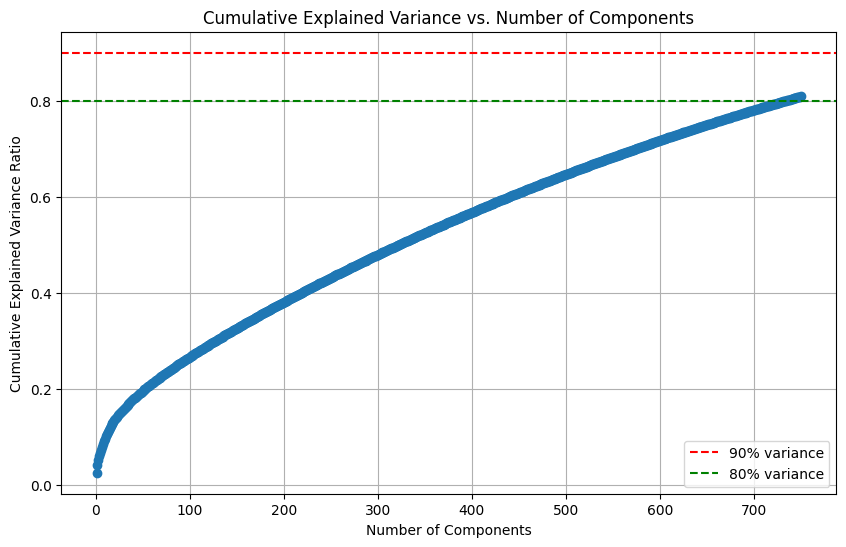

In [55]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

print("Cumulative explained variance ratio for the first 100 components:")
for i, variance in enumerate(cumulative_variance_ratio[:100]):
    print(f"Components {i+1}: {variance:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% variance')
plt.axhline(y=0.8, color='g', linestyle='--', label='80% variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.grid(True)
plt.legend()
plt.show()

In [56]:
feature_names = lemming.get_feature_names_out()
mask = abs(pca.components_[0]) > np.percentile(abs(pca.components_[0]), 70)
new_features = feature_names[mask]
filtered_features = pca.components_[:, mask]


In [57]:
top_n = 20

keywords_per_doc = []
for i in range(X_pca.shape[0]):
    scores = X_pca[i].flatten()
    component_loadings = np.abs(filtered_features)
    weighted_loadings = np.dot(np.abs(scores), component_loadings)
    weighted_loadings = weighted_loadings / np.sum(weighted_loadings)
    feature_scores = list(zip(new_features, weighted_loadings))
    sorted_features = sorted(feature_scores, key=lambda x: x[1], reverse=True)[:top_n]
    keywords_dict = {word: float(round(score, 3)) for word, score in sorted_features}
    keywords_per_doc.append(keywords_dict)
for keywords in keywords_per_doc[:5]:
    print(keywords)

{'january 6': 0.0, 'dvornikov': 0.0, 'november 12': 0.0, 'july 19': 0.0, 'january 20': 0.0, 'march 11': 0.0, 'april 9': 0.0, 'october 21': 0.0, 'russian': 0.0, 'october 18': 0.0, 'november 11': 0.0, '11 2023': 0.0, 'january 22': 0.0, 'january 25': 0.0, 'january 8': 0.0, 'october 14': 0.0, 'october 2': 0.0, 'february 19': 0.0, 'september 6': 0.0, 'december 16': 0.0}
{'russian': 0.0, 'april 9': 0.0, 'january 6': 0.0, 'november 12': 0.0, 'march 18': 0.0, 'dvornikov': 0.0, 'march 11': 0.0, 'october 10': 0.0, 'january 20': 0.0, 'october 21': 0.0, 'january 22': 0.0, 'september 6': 0.0, 'october 18': 0.0, 'july 24': 0.0, 'october 14': 0.0, 'february 25': 0.0, 'july 19': 0.0, 'ukrainian': 0.0, 'january 8': 0.0, 'october 2': 0.0}
{'russian': 0.0, 'force': 0.0, 'ukrainian': 0.0, 'putin': 0.0, 'dot': 0.0, 'march': 0.0, 'april': 0.0, 'march 18': 0.0, '”': 0.0, 'march 11': 0.0, 'february': 0.0, 'january 6': 0.0, 'ukraine': 0.0, 'prigozhin': 0.0, 'russia': 0.0, 'dvornikov': 0.0, 'drone': 0.0, 'sever

In [58]:
# keywords_per_doc = []
# top_n = 1000  # Reduced to match your last variant
#
# for i in range(X_tf_idf.shape[0]):
#     row = X_tf_idf[i]
#     indices = row.indices
#     scores = row.data
#     if len(scores) > top_n:
#         top_indices = np.argpartition(scores, -top_n)[-top_n:]  # Top N indices
#         feature_scores = [(feature_names[indices[idx]], scores[idx]) for idx in top_indices]
#         sorted_features = sorted(feature_scores, key=lambda x: x[1], reverse=True)
#     else:
#         feature_scores = [(feature_names[idx], score) for idx, score in zip(indices, scores)]
#         sorted_features = sorted(feature_scores, key=lambda x: x[1], reverse=True)
#     keywords_dict = {word: float(round(score, 3)) for word, score in sorted_features}
#     keywords_per_doc.append(keywords_dict)
#
# for keywords in keywords_per_doc:
#     print(keywords)